# **Практическая работа №8. Генеративно-состязательная сеть (GAN). Часть 1**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1i3NlGFJbY6hvm-ropSFobW9_nqUcqzPS?usp=sharing)

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels)

In [3]:
from tensorflow.keras.models import load_model, save_model
import os

models_path = r'.\models\anime'
gan_path = os.path.join(models_path, "gan")
generator_path = os.path.join(models_path, "generator")
discriminator_path = os.path.join(models_path, "discriminator")

def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, gan_path)
    discriminator.trainable = True
    save_model(generator, generator_path)
    save_model(discriminator, discriminator_path)

def load():
    discriminator = load_model(discriminator_path)
    generator = load_model(generator_path)
    gan = load_model(gan_path)
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [4]:
from sklearn.model_selection import train_test_split
from imutils import paths
import random 
import cv2

def load_data():
    imagePaths = sorted(list(paths.list_images(r"./data/anime/")))
    random.shuffle(imagePaths)
    allX = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (img_cols, img_rows))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        allX.append(image)

    allX = np.array(allX)
    return (allX, None), (None, None)

### Загрузка и деомнстрация данных

In [5]:
(images, _), (_, _) =load_data()

In [6]:
images.shape

(63565, 64, 64, 3)

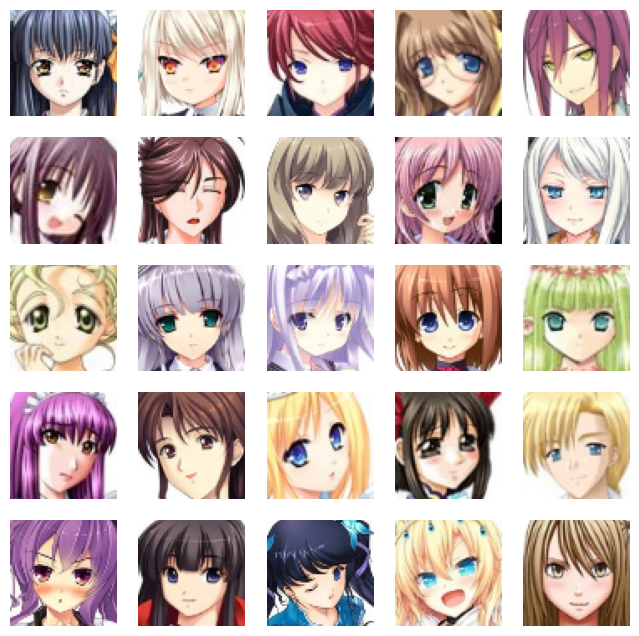

In [7]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [8]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            #axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(r".\train_images\House_Room_Dataset", "generated_epoch_%d.png" % epoch) )
    plt.close()

In [14]:

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout,MaxPooling2D, UpSampling2D,ZeroPadding2D
from tensorflow.keras.layers import Activation, LeakyReLU, Concatenate, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from numpy import load, zeros, ones
from numpy.random import randint
from matplotlib import pyplot
import time
from tensorflow.keras.models import load_model
import keras
import tensorflow as tf

In [16]:
image=tf.data.Dataset.list_files(os.path.join('./data/anime/images','*jpg')).as_numpy_iterator()

In [17]:
def load_image(path):
    image=tf.io.read_file(path)
    image=tf.io.decode_jpeg(image)
    image=tf.image.resize(image,size=(64,64))
    image=image/255.0
    return image

(64, 64, 3)


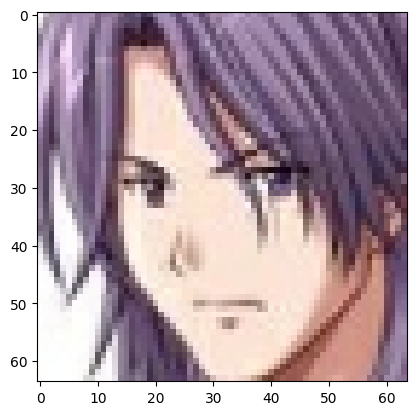

In [18]:
img=load_image(image.next())
print(img.shape)
plt.imshow(img)
plt.show()

In [19]:
data=tf.data.Dataset.list_files(os.path.join('./data/anime/images','*jpg'))
data=data.map(load_image)
data=data.batch(64)
data=data.prefetch(tf.data.AUTOTUNE)
data_iterator=data.as_numpy_iterator()

In [20]:
def show_images(images):
    idx=0
    fig,ax=plt.subplots(nrows=4,ncols=8,figsize=(20,10))
    for row in range(4):
        for col in range(8):
            ax[row][col].imshow(images[idx])
            ax[row][col].axis('off')
            idx+=1
    fig.tight_layout()

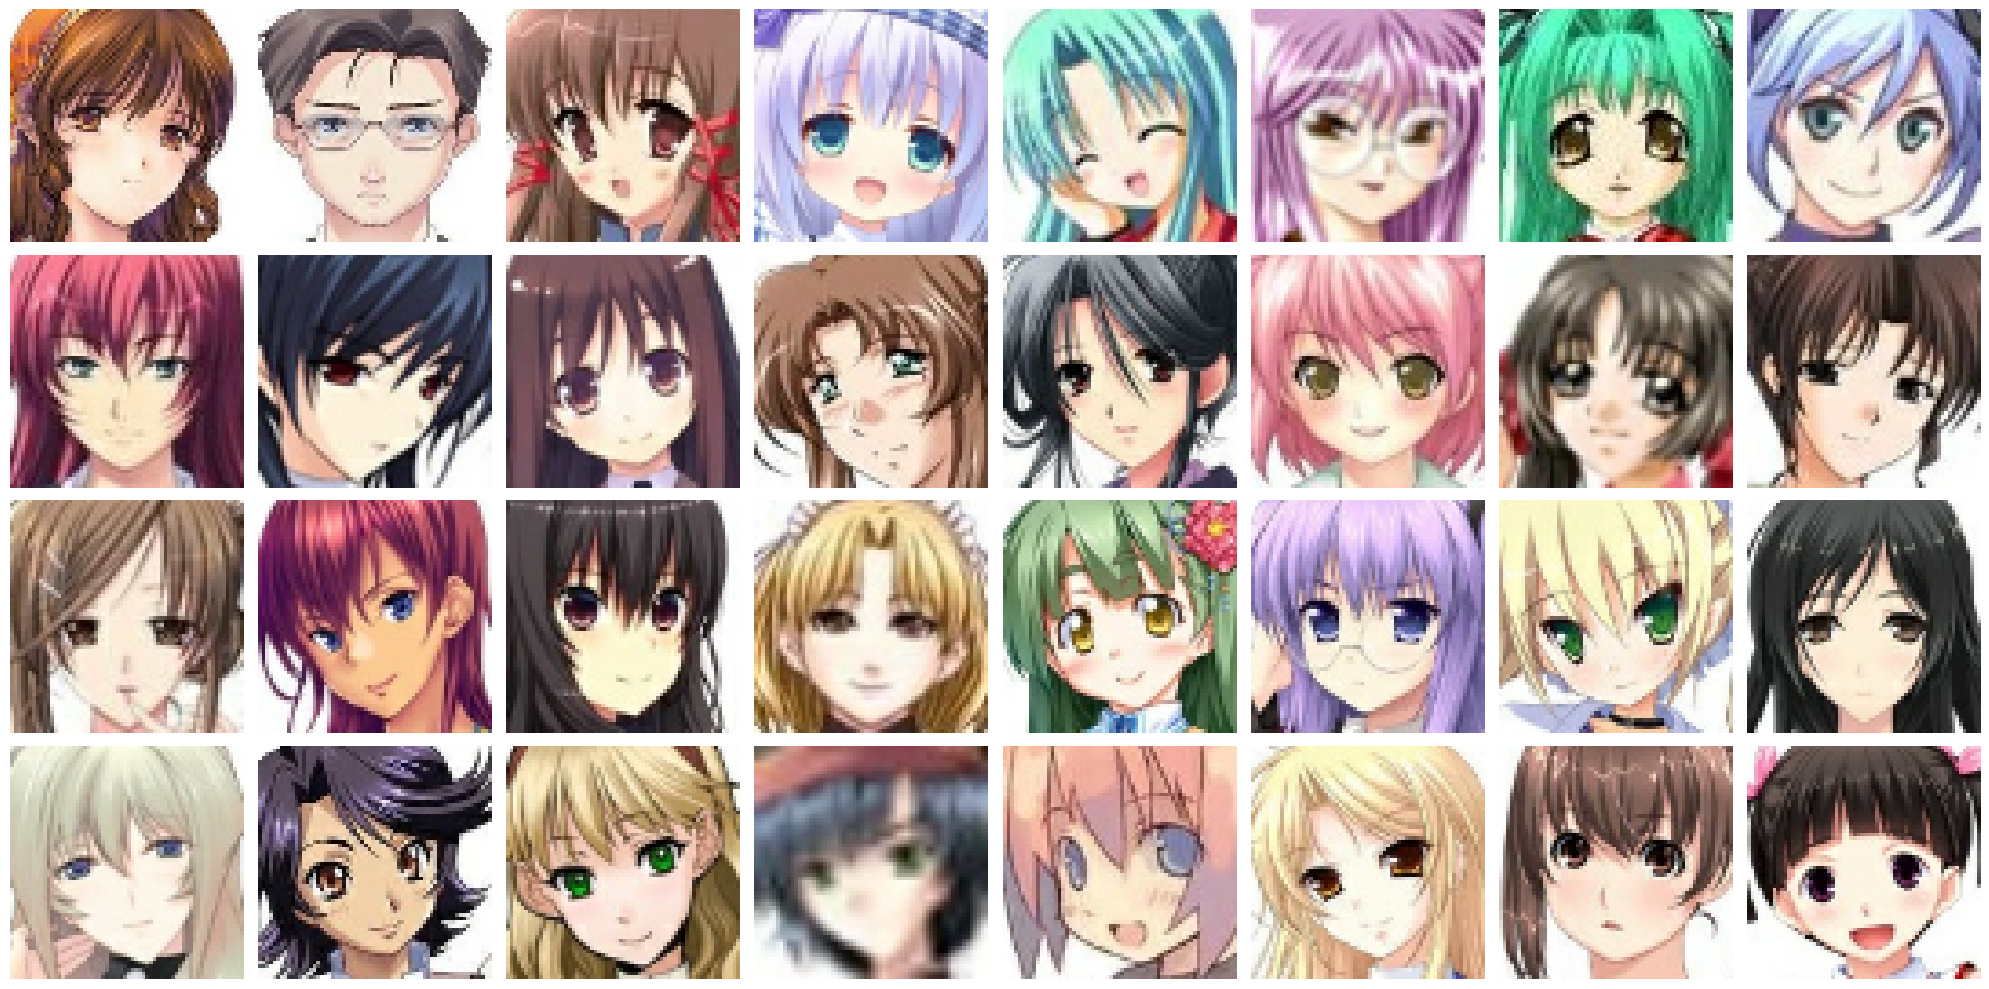

In [21]:
images=data_iterator.next()
show_images(images)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2DTranspose,Reshape,BatchNormalization,Conv2D,MaxPool2D,Flatten
import numpy as np

### Генератор

In [23]:
def build_generator():
    model=Sequential(name='generator')

    model.add(Dense(4*4*128,input_shape=(128,)))
    model.add(Reshape((4,4,128)))
    model.add(Conv2DTranspose(64,(4,4),2,padding='same',activation='relu',kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64,(4,4),2,padding='same',activation='relu',kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(32,(4,4),2,padding='same',activation='relu',kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(32,(4,4),2,padding='same',activation='relu',kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(3,(4,4),1,padding='same',activation='sigmoid',kernel_initializer='random_uniform'))
    return model

In [24]:
generator=build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              264192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 64)          131136    
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 64)        65600     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 32)        32

(128, 64, 64, 3)


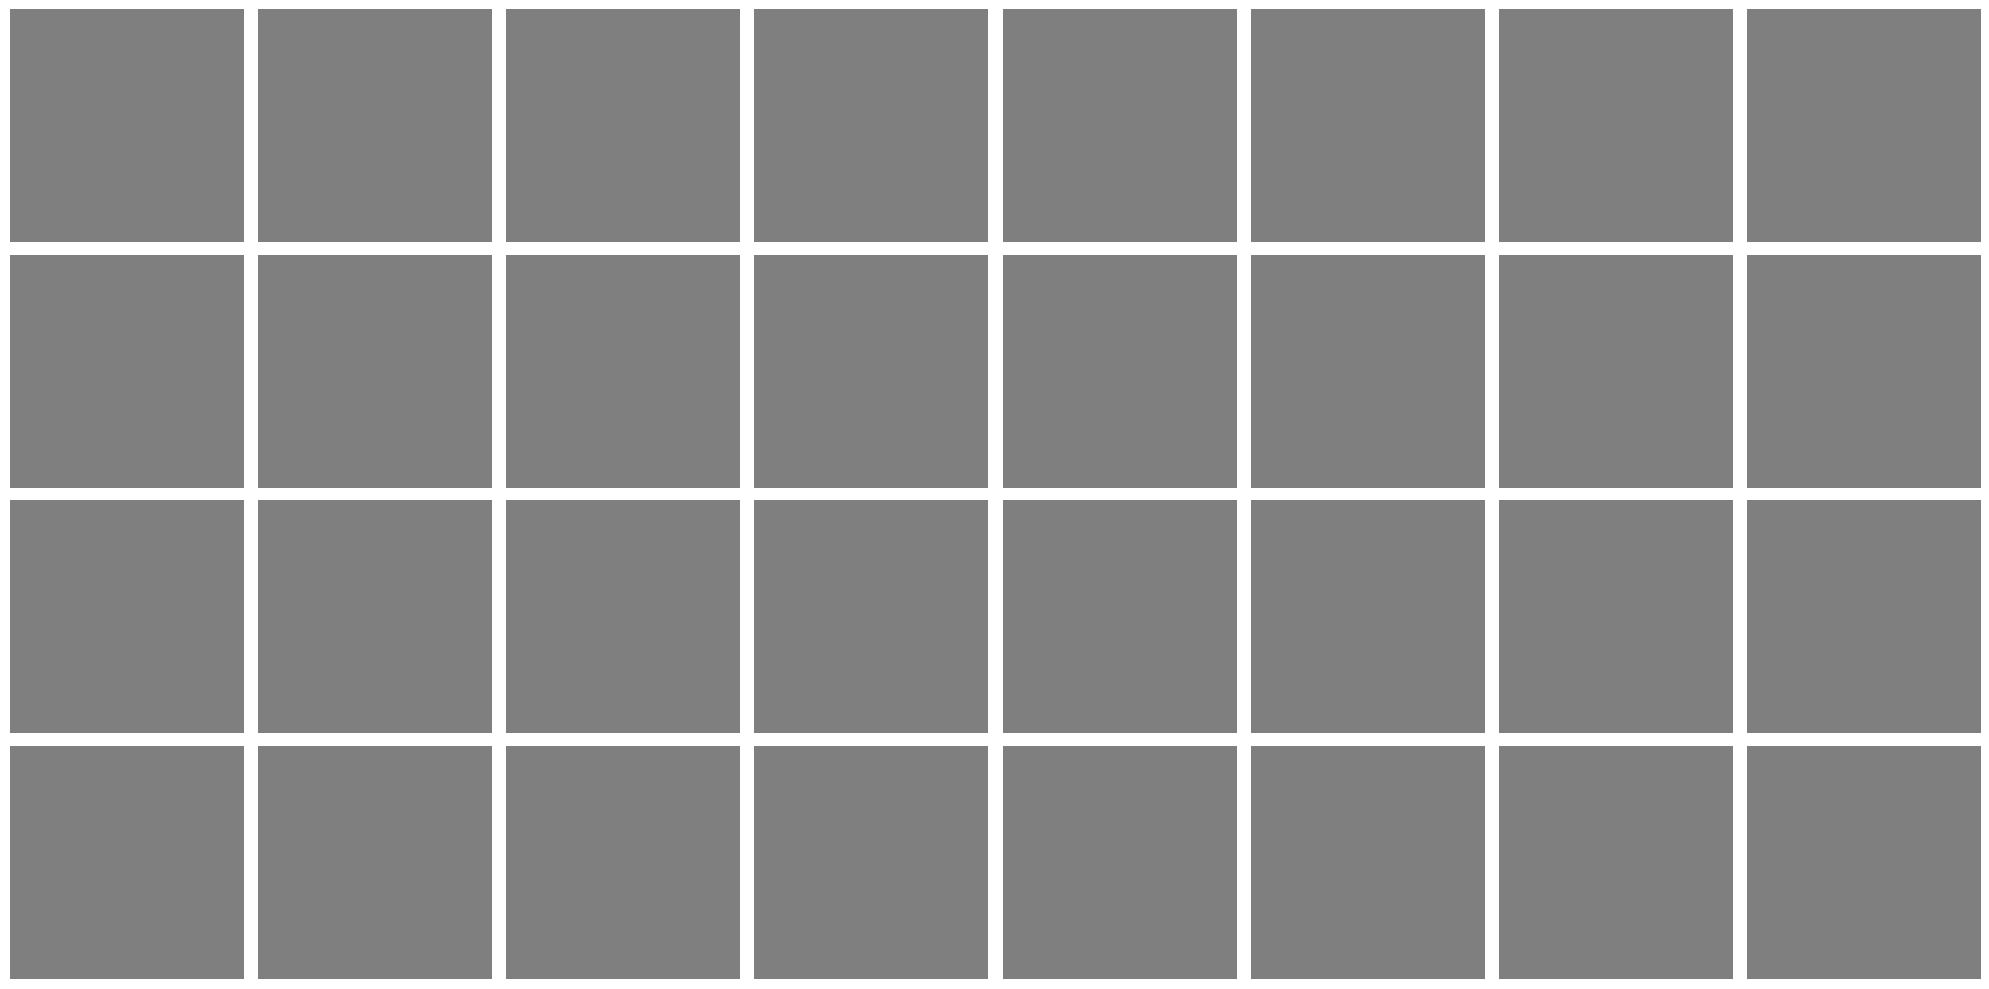

In [25]:
images=generator.predict(np.random.randn(128,128),verbose=0)
print(images.shape)
show_images(images)

### Дискриминатор

In [26]:
def build_discriminator():
    model=Sequential(name='discriminator')

    model.add(Conv2D(32,(5,5),1,input_shape=(64,64,3)))
    model.add(MaxPool2D())
    model.add(Conv2D(64,(5,5),1,activation='relu',kernel_initializer='he_normal'))
    model.add(Conv2D(64,(4,4),1,activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D())
    model.add(Conv2D(64,(3,3),1,activation='relu',kernel_initializer='he_normal'))
    model.add(Conv2D(64,(3,3),1,activation='relu',kernel_initializer='he_normal'))
    model.add(Conv2D(128,(3,3),1,activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    return model

In [27]:
discriminator=build_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 64)        51264     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 64)        65600     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)        

In [28]:
discriminator(data_iterator.next()[:10])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.53122354],
       [0.5164817 ],
       [0.5287496 ],
       [0.5010151 ],
       [0.53610694],
       [0.5256407 ],
       [0.53281057],
       [0.52046233],
       [0.5529646 ],
       [0.51969045]], dtype=float32)>

### Компиляция модели

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

generator_opt=Adam(learning_rate=0.0001)
discriminator_opt=Adam(learning_rate=0.001)
generator_loss=BinaryCrossentropy()
discriminator_loss=BinaryCrossentropy()

In [30]:
class AnimeGAN(tf.keras.models.Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.generator=generator
        self.discriminator=discriminator
    
    def compile(self,g_opt,g_loss,d_opt,d_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        self.generator_loss=g_loss
        self.generator_opt=g_opt
        self.discriminator_loss=d_loss
        self.discriminator_opt=d_opt
    
    def train_step(self,batch):
        # извлечение данных
        fake_images=self.generator(np.random.randn(128,128),training=False)
        real_images=batch

        # обучающий дискриминатор
        with tf.GradientTape() as d_tape:
# дискриминатор выводит 0: реальные изображения, 1: поддельные изображения
            yhat_real=self.discriminator(real_images,training=True)
            yhat_fake=self.discriminator(fake_images,training=True)
            yhat_realfake=tf.concat([yhat_real,yhat_fake],axis=0)
            y_realfake=tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            d_loss = self.discriminator_loss(y_realfake, yhat_realfake)
        # применить обратное распространение для обучения дискриминатора
        d_grad=d_tape.gradient(d_loss,self.discriminator.trainable_variables)
        self.discriminator_opt.apply_gradients(zip(d_grad,self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            g_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels) 

        ggrad = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.generator_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'g_loss':g_loss,'d_loss':d_loss}

In [31]:
animeGAN=AnimeGAN(generator,discriminator)
animeGAN.compile(generator_opt,generator_loss,discriminator_opt,discriminator_loss)

### Обучение модели

In [32]:
history=animeGAN.fit(data,epochs=100)

Epoch 1/100
994/994 [==============================] - 86s 84ms/step - g_loss: 1.1101 - d_loss: 0.3704
Epoch 2/100
994/994 [==============================] - 83s 83ms/step - g_loss: 2.2511 - d_loss: 0.3565
Epoch 3/100
994/994 [==============================] - 83s 83ms/step - g_loss: 1.8544 - d_loss: 0.3428
Epoch 4/100
994/994 [==============================] - 83s 84ms/step - g_loss: 1.5045 - d_loss: 0.3152
Epoch 5/100
994/994 [==============================] - 83s 84ms/step - g_loss: 0.8776 - d_loss: 0.2904
Epoch 6/100
994/994 [==============================] - 83s 84ms/step - g_loss: 0.6570 - d_loss: 0.2976
Epoch 7/100
994/994 [==============================] - 83s 84ms/step - g_loss: 0.4470 - d_loss: 0.2834
Epoch 8/100
994/994 [==============================] - 83s 84ms/step - g_loss: 0.5041 - d_loss: 0.2814
Epoch 9/100
994/994 [==============================] - 83s 84ms/step - g_loss: 0.2755 - d_loss: 0.2753
Epoch 10/100
994/994 [==============================] - 83s 84ms/step - g

### Демонстрация сгенерированных изображений:

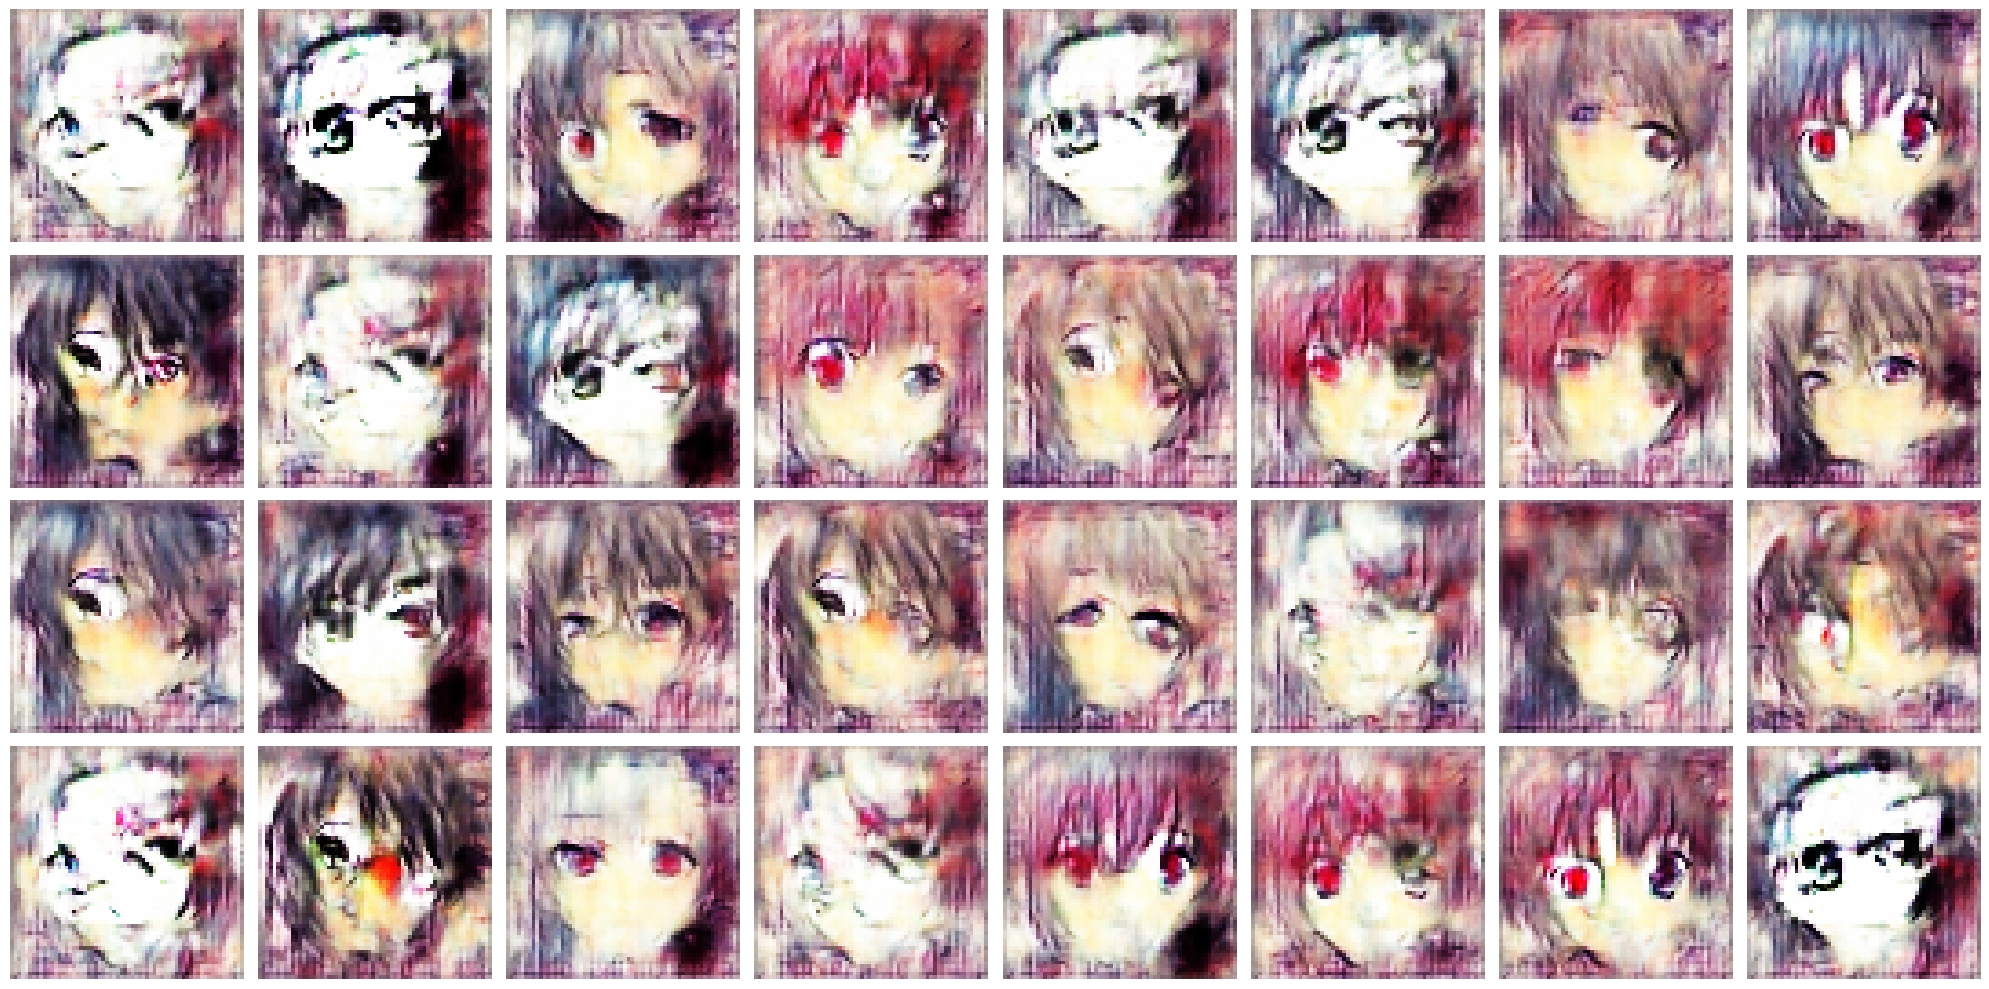

In [63]:
images=generator.predict(np.random.randn(32,128),verbose=0)
show_images(images)

In [33]:
if not os.path.exists('metadata'):
    os.mkdir('metadata')
generator.save('./metadata/')
discriminator.save('./metadata/')
if not os.path.exists('models'):
    os.mkdir('models')
tf.keras.models.save_model(generator,os.path.join('models','generator.h5'))
tf.keras.models.save_model(discriminator,os.path.join('models','discriminator.h5'))

INFO:tensorflow:Assets written to: ./metadata/assets
INFO:tensorflow:Assets written to: ./metadata/assets
